# Expérimentation avec la distance de Hamming et la similarité du Cosine

In [98]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.spatial.distance import hamming

In [16]:
rebecca1, sr1 =librosa.load("rebecca.wav")
rebecca2, sr2 =librosa.load("rebecca2.wav")


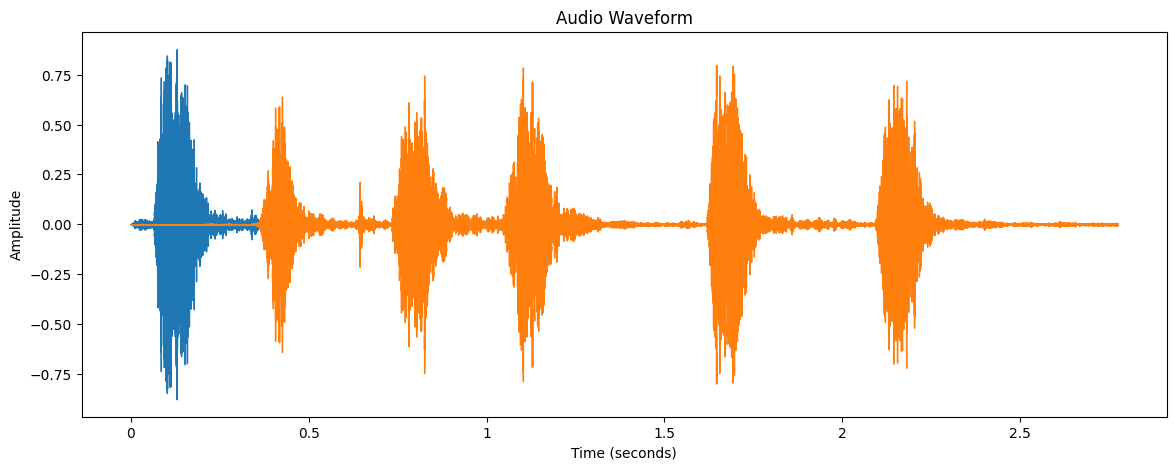

In [18]:

plt.figure(figsize=(14, 5))
librosa.display.waveshow(rebecca1, sr=sr1)
librosa.display.waveshow(rebecca2, sr=sr2)
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
y_ref = librosa.util.normalize(rebecca1)
y_sample = librosa.util.normalize(rebecca2)

# Use cross-correlation to find the best alignment
correlation = correlate(y_ref, y_sample, mode='full')
max_corr_idx = np.argmax(correlation)
offset = max_corr_idx - len(y_ref) + 1

# Align the signals
if offset >= 0:
    # Pad reference at the beginning
    aligned_ref = np.pad(y_ref, (0, max(0, len(y_sample) + offset - len(y_ref))))
    aligned_sample = np.pad(y_sample, (offset, 0))
else:
    # Pad sample at the beginning
    aligned_ref = np.pad(y_ref, (abs(offset), 0))
    aligned_sample = np.pad(y_sample, (0, max(0, len(y_ref) - abs(offset) - len(y_sample))))

# Ensure both have the same length
min_len = min(len(aligned_ref), len(aligned_sample))
aligned_ref = aligned_ref[:min_len]
aligned_sample = aligned_sample[:min_len]


In [37]:
# Calculate similarity using different methods
# 1. Calculate cosine similarity using their features
mfcc_ref = librosa.feature.mfcc(y=aligned_ref, sr=sr1, n_mfcc=13)
mfcc_sample = librosa.feature.mfcc(y=aligned_sample, sr=sr2, n_mfcc=13)

# Reshape for cosine similarity calculation
mfcc_ref_flat = mfcc_ref.reshape(1, -1)
mfcc_sample_flat = mfcc_sample.reshape(1, -1)

cos_sim = cosine_similarity(mfcc_ref_flat, mfcc_sample_flat)[0][0]

# 2. Calculate a simple waveform similarity
waveform_diff = np.mean(np.abs(aligned_ref - aligned_sample))

print(f"Alignment offset: {offset} samples ({offset/sr1:.3f} seconds)")
print(f"MFCC Cosine similarity: {cos_sim:.4f}")
print(f"Waveform difference: {waveform_diff:.4f}")

Alignment offset: -16572 samples (-0.752 seconds)
MFCC Cosine similarity: 0.7524
Waveform difference: 0.0579


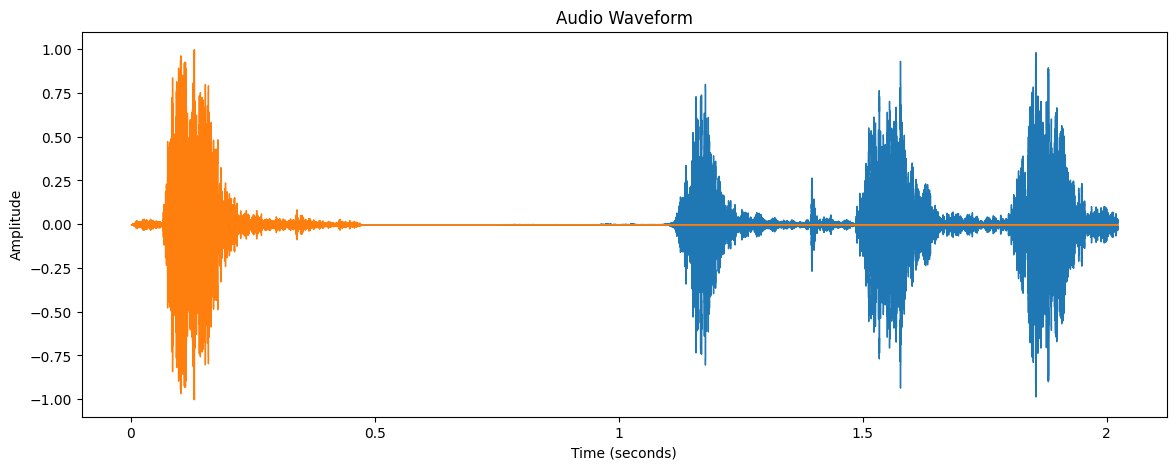

In [38]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(aligned_ref, sr=sr1)
librosa.display.waveshow(aligned_sample, sr=sr1)
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
def segment_barks(audio_data, sr, threshold=0.1, min_duration=0.1, plot=True):
    """
    Segment an audio array containing multiple barks into individual bark segments.
    
    """ 
    
    # Normalize
    y = librosa.util.normalize(audio_data)
    
    # Calculate envelope
    envelope = np.abs(y)
    
    # Find segments above threshold
    is_above = envelope > threshold
    
    # Find state changes
    state_changes = np.diff(is_above.astype(int))
    rising_edges = np.where(state_changes == 1)[0]
    falling_edges = np.where(state_changes == -1)[0]
    
    # Make sure we have paired edges
    if len(rising_edges) == 0 or len(falling_edges) == 0:
        print("No clear segments detected. Try adjusting threshold.")
        return []
    
    # Ensure we start with a rising edge and end with a falling edge
    if falling_edges[0] < rising_edges[0]:
        falling_edges = falling_edges[1:]
    if len(rising_edges) > len(falling_edges):
        rising_edges = rising_edges[:-1]
    
    segments = []
    min_samples = int(min_duration * sr)
    segment_times = []
    
    for start, end in zip(rising_edges, falling_edges):
        # Add a small buffer
        buffer = int(0.05 * sr)
        seg_start = max(0, start - buffer)
        seg_end = min(len(y), end + buffer)
        
        if (seg_end - seg_start) >= min_samples:
            segments.append(y[seg_start:seg_end])
            segment_times.append((seg_start/sr, seg_end/sr))
    
    print(f"Found {len(segments)} bark segments")
    
    return segments, segment_times

In [51]:
seg1, n1 = segment_barks(y_ref, sr1)
seg2, n2 = segment_barks(y_sample, sr1)


Found 1246 bark segments
Found 225 bark segments


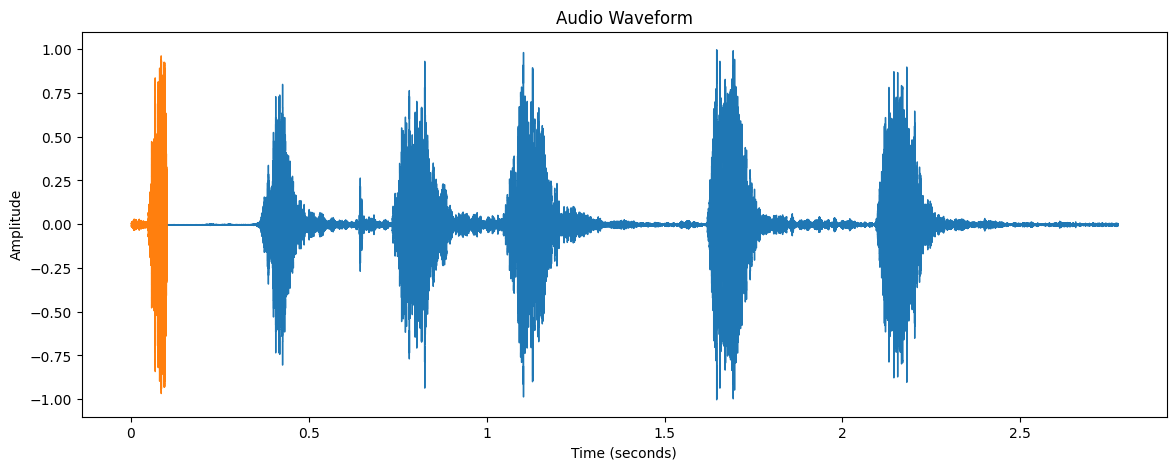

In [57]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y_ref, sr=sr1)
librosa.display.waveshow(seg2[1], sr=sr1)
plt.title("Audio Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
def synchronize_and_compare(reference_bark, sample_bark, sr, plot=True):
    """
    Synchronize two bark segments and calculate similarity.
    """ 
    
    # Make copies to avoid modifying originals
    ref = np.copy(reference_bark)
    sample = np.copy(sample_bark)
    
    # Normalize both signals
    ref = librosa.util.normalize(ref)
    sample = librosa.util.normalize(sample)
    
    # Use cross-correlation to find the best alignment
    correlation = correlate(ref, sample, mode='full')
    max_corr_idx = np.argmax(correlation)
    offset = max_corr_idx - len(ref) + 1
    
    print(f"Alignment offset: {offset} samples ({offset/sr:.3f} seconds)")
    
    # Align the signals
    if offset >= 0:
        # Pad reference at the beginning
        aligned_ref = np.pad(ref, (0, max(0, len(sample) + offset - len(ref))))
        aligned_sample = np.pad(sample, (offset, 0))
    else:
        # Pad sample at the beginning
        aligned_ref = np.pad(ref, (abs(offset), 0))
        aligned_sample = np.pad(sample, (0, max(0, len(ref) - abs(offset) - len(sample))))
    
    # Ensure both have the same length
    min_len = min(len(aligned_ref), len(aligned_sample))
    aligned_ref = aligned_ref[:min_len]
    aligned_sample = aligned_sample[:min_len]
    
    # Calculate cosine similarity using their features
    mfcc_ref = librosa.feature.mfcc(y=aligned_ref, sr=sr, n_mfcc=13)
    mfcc_sample = librosa.feature.mfcc(y=aligned_sample, sr=sr, n_mfcc=13)
    
    # Reshape for cosine similarity calculation
    mfcc_ref_flat = mfcc_ref.reshape(1, -1)
    mfcc_sample_flat = mfcc_sample.reshape(1, -1)
    
    cos_sim = cosine_similarity(mfcc_ref_flat, mfcc_sample_flat)[0][0]
    
    # # 2. Calculate a simple waveform correlation
    # corr = np.corrcoef(aligned_ref, aligned_sample)[0, 1]
    
    # print(f"MFCC Cosine similarity: {cos_sim:.4f}")
    # print(f"Waveform correlation: {corr:.4f}")
    
    # # 3. Calculate a spectral similarity
    # spec_ref = np.abs(librosa.stft(aligned_ref))
    # spec_sample = np.abs(librosa.stft(aligned_sample))
    # spec_ref_flat = spec_ref.reshape(1, -1)
    # spec_sample_flat = spec_sample.reshape(1, -1)
    # spec_sim = cosine_similarity(spec_ref_flat, spec_sample_flat)[0][0]
    # print(f"Spectral similarity: {spec_sim:.4f}")
    
    # # Visualize if requested
    # if plot:
    #     plt.figure(figsize=(12, 9))
        
    #     # Plot original signals
    #     plt.subplot(3, 1, 1)
    #     librosa.display.waveshow(ref, sr=sr, alpha=0.8, color='orange')
    #     plt.title("Reference Bark")
    #     plt.xlabel("")
        
    #     plt.subplot(3, 1, 2)
    #     librosa.display.waveshow(sample, sr=sr, alpha=0.8, color='blue')
    #     plt.title("Sample Bark")
    #     plt.xlabel("")
        
    #     # Plot aligned signals
    #     plt.subplot(3, 1, 3)
    #     librosa.display.waveshow(aligned_ref, sr=sr, alpha=0.6, color='orange', label='Reference')
    #     librosa.display.waveshow(aligned_sample, sr=sr, alpha=0.6, color='blue', label='Sample')
    #     plt.title(f"Aligned Barks (Similarity: {cos_sim:.4f})")
    #     plt.legend()
        
    #     plt.tight_layout()
    #     plt.show()
    
    return cos_sim

In [90]:
cos_sim = np.array([synchronize_and_compare(y_ref, seg2[i], sr1) for i in range(len(seg2))])

Alignment offset: -51806 samples (-2.349 seconds)
Alignment offset: -51787 samples (-2.349 seconds)
Alignment offset: -51751 samples (-2.347 seconds)
Alignment offset: -35872 samples (-1.627 seconds)
Alignment offset: -35861 samples (-1.626 seconds)
Alignment offset: -42923 samples (-1.947 seconds)
Alignment offset: -42908 samples (-1.946 seconds)
Alignment offset: -42892 samples (-1.945 seconds)
Alignment offset: -42867 samples (-1.944 seconds)
Alignment offset: -42852 samples (-1.943 seconds)
Alignment offset: -42838 samples (-1.943 seconds)
Alignment offset: -42823 samples (-1.942 seconds)
Alignment offset: -42815 samples (-1.942 seconds)
Alignment offset: -42806 samples (-1.941 seconds)
Alignment offset: -36295 samples (-1.646 seconds)
Alignment offset: -36281 samples (-1.645 seconds)
Alignment offset: -42770 samples (-1.940 seconds)
Alignment offset: -42754 samples (-1.939 seconds)
Alignment offset: -36226 samples (-1.643 seconds)
Alignment offset: -36209 samples (-1.642 seconds)


In [84]:
np.argmax(cos_sim)

np.int64(215)

In [ ]:
nina, sr3 = librosa.load("nina.wav")

seg3, n3 = segment_barks(nina, sr3)

Found 224 bark segments
22050


In [93]:
cos_sim_nina = np.array([synchronize_and_compare(y_ref, seg3[i], sr1) for i in range(len(seg3))])

Alignment offset: -35921 samples (-1.629 seconds)
Alignment offset: -35902 samples (-1.628 seconds)
Alignment offset: -35886 samples (-1.627 seconds)
Alignment offset: -35872 samples (-1.627 seconds)
Alignment offset: -35843 samples (-1.626 seconds)
Alignment offset: -35830 samples (-1.625 seconds)
Alignment offset: -35818 samples (-1.624 seconds)
Alignment offset: -36066 samples (-1.636 seconds)
Alignment offset: -36042 samples (-1.635 seconds)
Alignment offset: -35756 samples (-1.622 seconds)
Alignment offset: -35737 samples (-1.621 seconds)
Alignment offset: -35720 samples (-1.620 seconds)
Alignment offset: -35705 samples (-1.619 seconds)
Alignment offset: -35691 samples (-1.619 seconds)
Alignment offset: -35672 samples (-1.618 seconds)
Alignment offset: -36311 samples (-1.647 seconds)
Alignment offset: -36296 samples (-1.646 seconds)
Alignment offset: -36282 samples (-1.645 seconds)
Alignment offset: -36266 samples (-1.645 seconds)
Alignment offset: -36253 samples (-1.644 seconds)


In [94]:
np.max(cos_sim_nina)

np.float32(0.9686861)

In [99]:


def calculate_hamming_distance(reference, sample):
    """
    Calcule la distance de Hamming entre deux signaux audio.
    
    Pour l'audio (valeurs continues), nous devons d'abord quantifier les signaux en valeurs binaires.
    """
    # Convertir les signaux audio en représentation binaire pour la distance de Hamming
    # Utiliser un seuil pour convertir les valeurs en binaire (présence/absence)
    threshold = 0.05  # Ajustez en fonction de votre niveau de bruit
    
    # On peut utiliser différentes approches pour la binarisation
    # Approche 1: Seuil direct sur l'amplitude
    binary_ref = np.abs(reference) > threshold
    binary_sample = np.abs(sample) > threshold
    
    # Calculer la distance de Hamming (pourcentage de positions différentes)
    # La fonction hamming de scipy retourne le rapport des positions différentes sur le total
    ham_dist = hamming(binary_ref, binary_sample)
    
    return ham_dist

In [110]:
len(seg2)

225

In [116]:
H = [ calculate_hamming_distance(seg1[i][:2000], seg2[j][:2000] ) for i in range(len(seg1)) for j in range(len(seg2))]

np.sort(H)[len(H)-20:]

array([0.8695, 0.8695, 0.8695, 0.8695, 0.8695, 0.8695, 0.8695, 0.8695,
       0.8695, 0.8695, 0.87  , 0.87  , 0.87  , 0.8705, 0.8705, 0.8705,
       0.871 , 0.871 , 0.8715, 0.8725])

In [117]:
H = [ calculate_hamming_distance(seg1[i][:2000], seg3[j][:2000] ) for i in range(len(seg1)) for j in range(len(seg3))]

np.sort(H)[len(H)-20:]

array([0.823 , 0.823 , 0.8235, 0.8235, 0.8235, 0.8235, 0.824 , 0.824 ,
       0.824 , 0.825 , 0.825 , 0.825 , 0.8255, 0.826 , 0.826 , 0.826 ,
       0.8265, 0.8265, 0.8275, 0.8285])

## Conclusion
La distance de hamming ne semble pas marcher, et la technique avec le cos non plus.  
Pour les deux on peut obtenir une similarité d'au moins 80% pour une comparaison entre les aboiements de mes chiens Nina et Rebecca, ce qui ne devrait pas arriver.    

En revanche, il se peut que par manque de connaissances en traitement du signal je m'y prenne mal.  
Si tel est le cas, il faudra que je m'instruise en traitement du signal avant de pouvoir démontrer leurs efficacités.  

Par conséquent, jusqu'à preuve du contraire, la distance de hamming et la technique du cos ne marchent pas pour identifier le chien à l'origine d'un aboiement.